In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

from datetime import date
import hisepy
import numpy as np
import os
import pandas as pd
import re
import scanpy as sc

## Helper functions

In [2]:
def cache_uuid_path(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    if not os.path.isdir(cache_path):
        hise_res = hisepy.reader.cache_files([uuid])
    filename = os.listdir(cache_path)[0]
    cache_file = '{p}/{f}'.format(p = cache_path, f = filename)
    return cache_file

In [3]:
def read_csv_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_csv(cache_file)
    return res

In [4]:
def read_parquet_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = pd.read_parquet(cache_file)
    return res

In [5]:
def read_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file)
    return res

In [6]:
def backed_adata_uuid(uuid):
    cache_file = cache_uuid_path(uuid)
    res = sc.read_h5ad(cache_file, backed = 'r')
    return res

In [7]:
def rm_cache_uuid(uuid):
    cache_path = '/home/jupyter/cache/{u}'.format(u = uuid)
    rm_call = 'rm -r {d}'.format(d = cache_path)
    os.system(rm_call)

In [8]:
def format_cell_type(cell_type):
    cell_type = re.sub('\\+', 'pos', cell_type)
    cell_type = re.sub('-', 'neg', cell_type)
    cell_type = re.sub(' ', '_', cell_type)
    return cell_type

In [9]:
def filename_cell_type(filename):
    cell_type = re.sub('.+L3_','',filename)
    cell_type = re.sub('_2024.+','',cell_type)
    cell_type = re.sub('_', ' ', cell_type)
    cell_type = re.sub('pos','+', cell_type)
    cell_type = re.sub('neg','-', cell_type)
    return cell_type

In [10]:
def element_id(n = 3):
    import periodictable
    from random import randrange
    rand_el = []
    for i in range(n):
        el = randrange(0,118)
        rand_el.append(periodictable.elements[el].name)
    rand_str = '-'.join(rand_el)
    return rand_str

## Markers for dotplots

In [11]:
broad_markers = [
    'CD3D', # T cells
    'CD3E', # T cells/NK
    'FCN1', # Monocytes/Myeloid
    'HBB', # Erythrocytes
    'IL7R', # T cells
    'MS4A1', # B cells
    'CD79A', # B cells
    'PPBP', # Platelets
    'IFI44L' # ISG-high
]

In [33]:
class_markers = [
    'CD44'
]

## Read cell type hierarchy

In [13]:
hierarchy_uuid = '1a44252c-8cab-4c8f-92c9-d8f3af633790'
hierarchy_df = read_csv_uuid(hierarchy_uuid)

## Identify files for use in HISE

In [14]:
search_id = 'calcium-krypton-hydrogen'

Retrieve files stored in our HISE project store

In [15]:
ps_df = hisepy.list_files_in_project_store('cohorts')
ps_df = ps_df[['id', 'name']]

Filter for files from the previous notebook using our search_id

In [16]:
search_df = ps_df[ps_df['name'].str.contains(search_id)]
search_df = search_df.sort_values('name')
search_df['AIFI_L3'] = [filename_cell_type(f) for f in search_df['name']]

In [17]:
search_df['AIFI_L3'].tolist()

['BaEoMaP cell', 'CLP cell', 'CMP cell', 'Erythrocyte', 'Platelet']

## Review BaEoMaP cell

In [18]:
cell_type = 'BaEoMaP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [19]:
type_uuid

'03706635-e35d-4fd5-b25b-b8dae718e35d'

In [20]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 03706635-e35d-4fd5-b25b-b8dae718e35d
Files have been successfully downloaded!


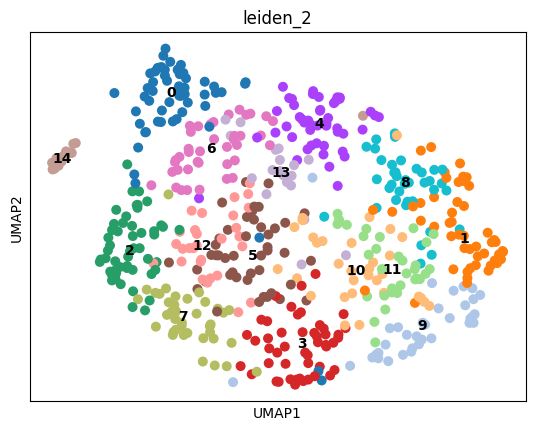

In [21]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

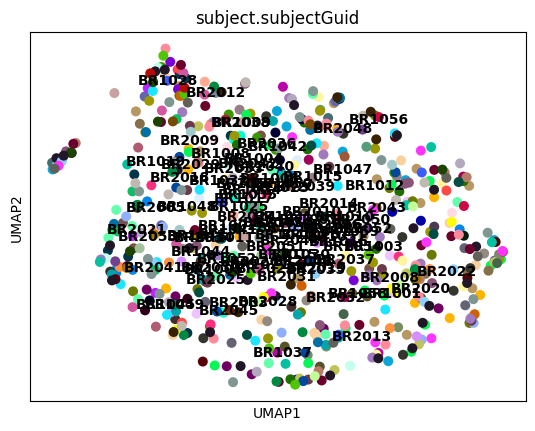

In [22]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

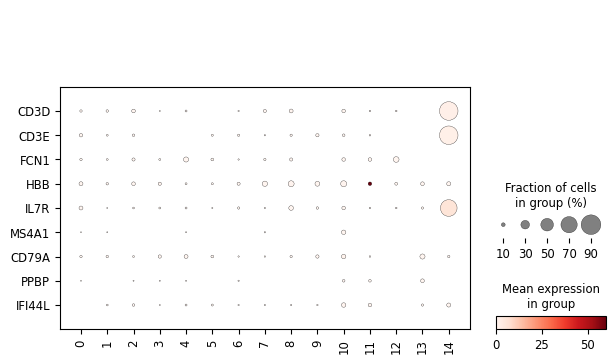

In [23]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

In [24]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     56
1     52
2     51
3     48
4     47
5     45
6     39
7     38
8     38
9     36
10    32
11    32
12    29
13    20
14    18
Name: count, dtype: int64

## Review CLP cell

In [25]:
cell_type = 'CLP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [26]:
type_uuid

'9c514698-74e8-41fb-8491-915e0e20903f'

In [27]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 9c514698-74e8-41fb-8491-915e0e20903f
Files have been successfully downloaded!


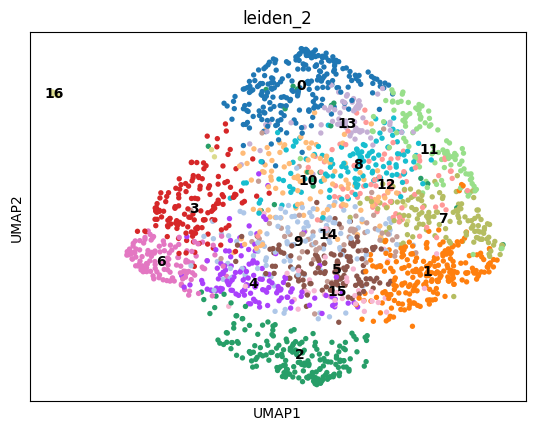

In [28]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

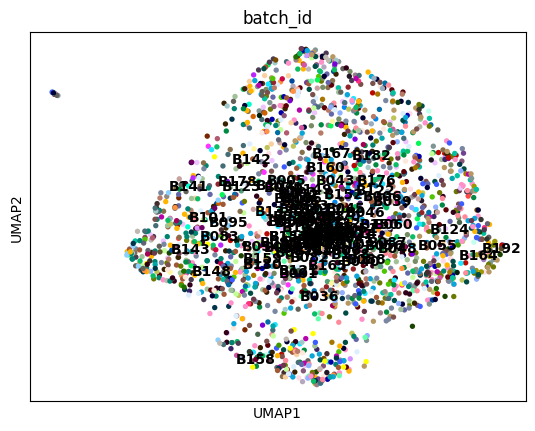

In [29]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

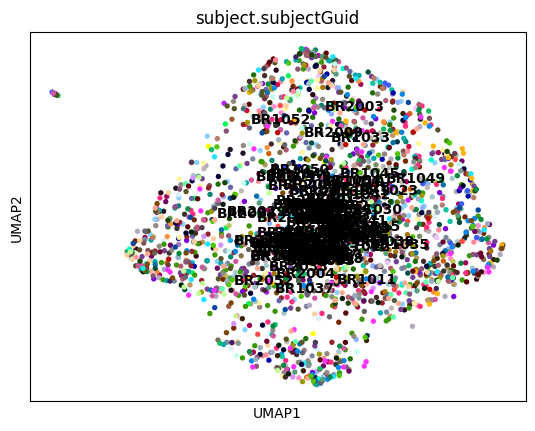

In [30]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

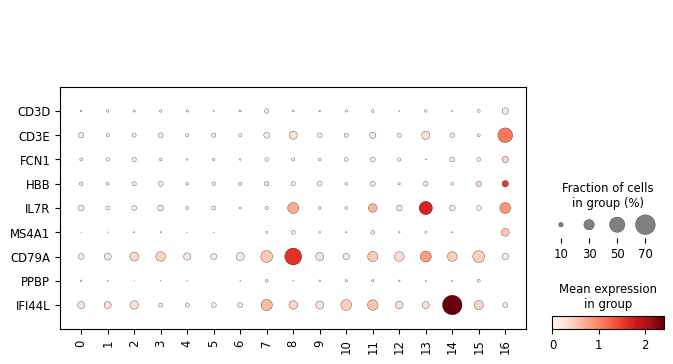

In [31]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

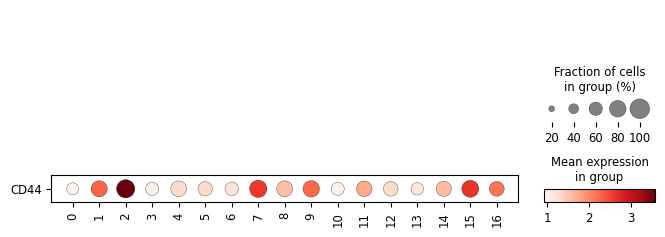

In [34]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [40]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     9109
1     9003
2     8100
3     7592
4     6763
5     6603
6     6544
7     6019
8     5847
9     5079
10    4237
11    3410
12    3362
13    2775
14    2692
15    2532
16    2163
17    1361
18     652
19      23
20      10
21       3
Name: count, dtype: int64

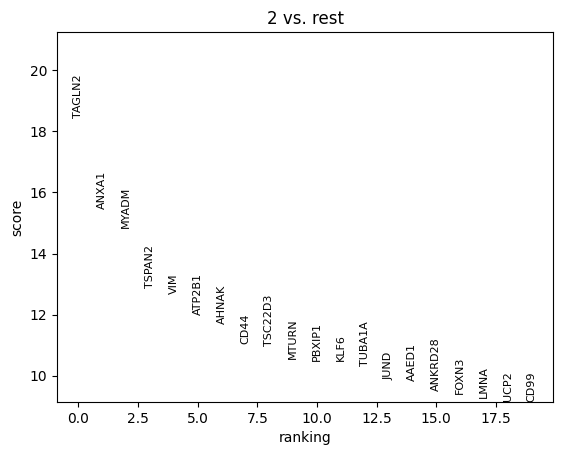

In [32]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['2']
)
sc.pl.rank_genes_groups(adata, ncols = 2)

## Review CMP cell

In [35]:
cell_type = 'CMP cell'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [36]:
type_uuid

'7dd7e9a7-d6e8-4c59-81d5-ba6404813714'

In [37]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 7dd7e9a7-d6e8-4c59-81d5-ba6404813714
Files have been successfully downloaded!


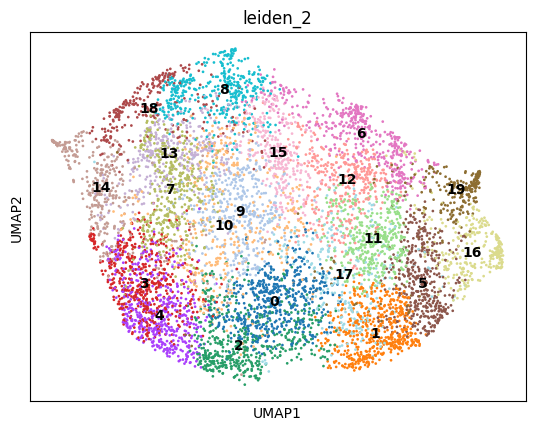

In [38]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

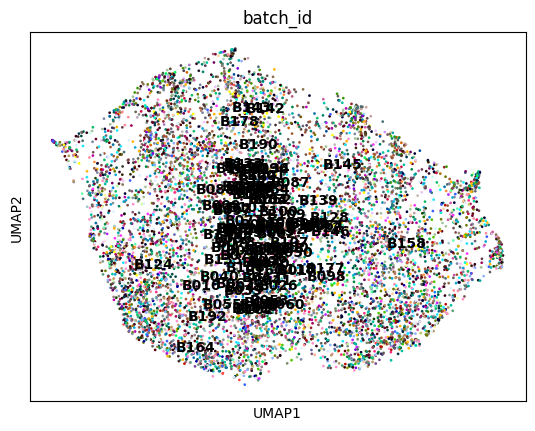

In [39]:
sc.pl.umap(adata, color = 'batch_id', legend_loc = 'on data')

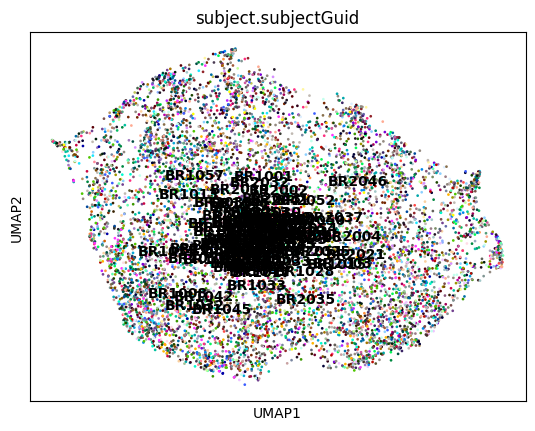

In [40]:
sc.pl.umap(adata, color = 'subject.subjectGuid', legend_loc = 'on data')

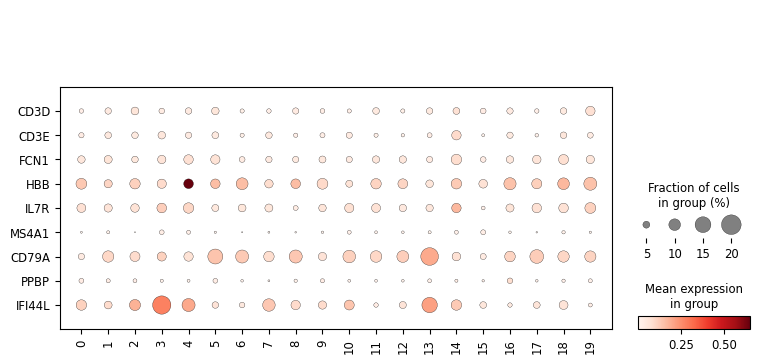

In [41]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

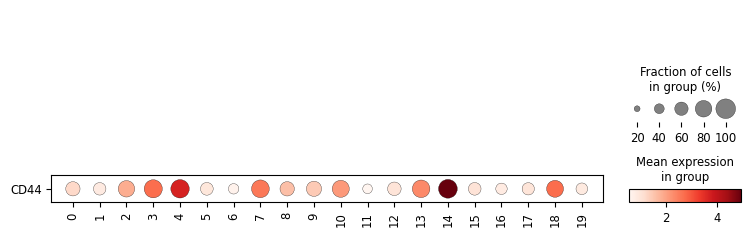

In [43]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [44]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     541
1     529
2     512
3     501
4     499
5     431
6     431
7     428
8     413
9     396
10    395
11    394
12    352
13    352
14    345
15    312
16    293
17    289
18    258
19    252
Name: count, dtype: int64

## Review Erythrocyte

In [45]:
cell_type = 'Erythrocyte'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [46]:
type_uuid

'315c0b4e-c5ae-48e5-a820-c86a9d368cf5'

In [47]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 315c0b4e-c5ae-48e5-a820-c86a9d368cf5
Files have been successfully downloaded!


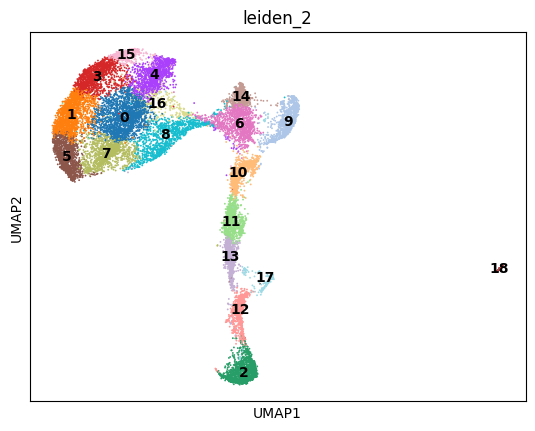

In [48]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

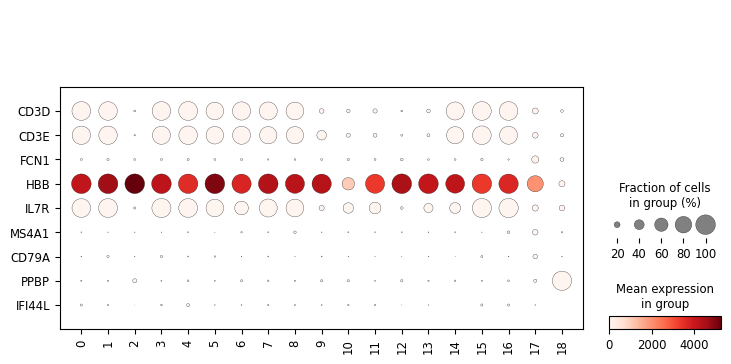

In [50]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

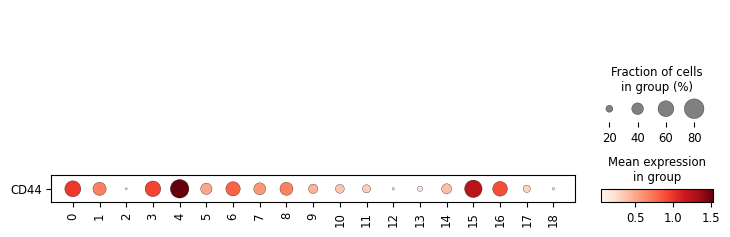

In [51]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [52]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     1808
1     1542
2     1270
3     1241
4     1175
5     1164
6     1100
7     1076
8     1061
9      969
10     873
11     776
12     769
13     676
14     557
15     350
16     310
17     231
18     166
Name: count, dtype: int64

## Review Platelet

In [53]:
cell_type = 'Platelet'
type_uuid = search_df['id'].loc[search_df['AIFI_L3'] == cell_type].tolist()[0]

In [54]:
type_uuid

'9361ddcf-b098-49ca-9812-8dd3f3ca7958'

In [55]:
adata = read_adata_uuid(type_uuid)

downloading fileID: 9361ddcf-b098-49ca-9812-8dd3f3ca7958
Files have been successfully downloaded!


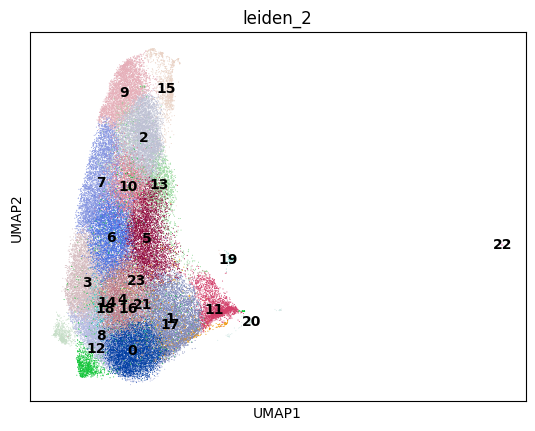

In [56]:
sc.pl.umap(adata, color = 'leiden_2', legend_loc = 'on data')

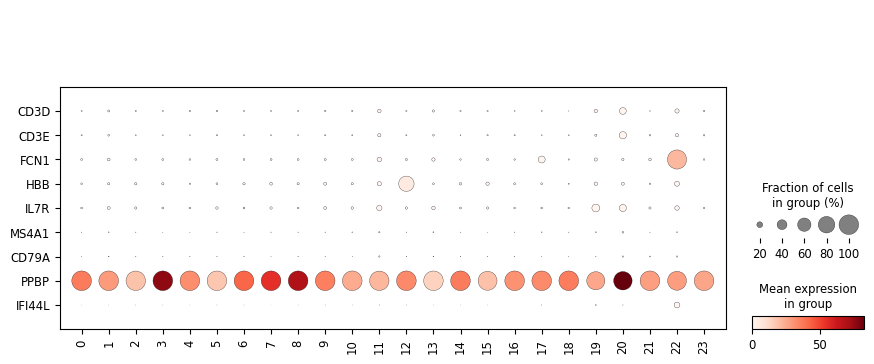

In [57]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = broad_markers, swap_axes = True)

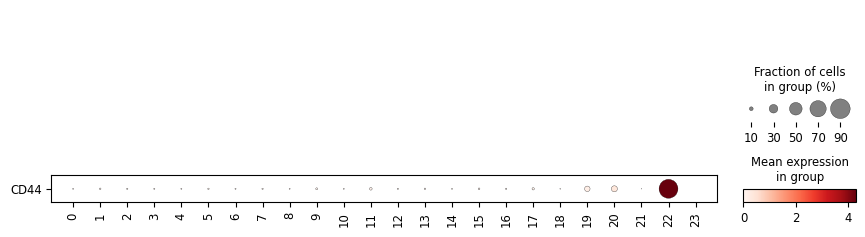

In [58]:
sc.pl.dotplot(adata, groupby = 'leiden_2', var_names = class_markers, swap_axes = True)

In [59]:
adata.obs['leiden_2'].value_counts()

leiden_2
0     5927
1     5596
2     5469
3     4670
4     4612
5     4234
6     4108
7     4041
8     3818
9     3786
10    2305
11    2141
12    1722
13    1586
14    1487
15    1137
16     601
17     595
18     568
19     275
20     160
21     150
22     117
23      30
Name: count, dtype: int64

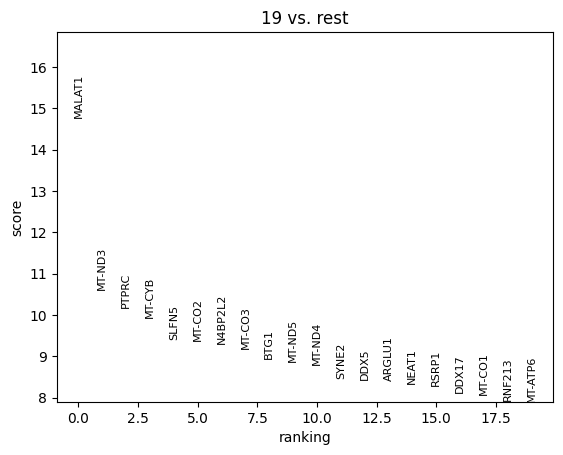

In [60]:
sc.tl.rank_genes_groups(
    adata, 
    groupby = 'leiden_2', 
    groups = ['19']
)
sc.pl.rank_genes_groups(adata, ncols = 2)